In [1]:
import optuna
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import optuna.integration.lightgbm as lgb
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV    
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import 20-bin gridded dataset
metadata_file = "metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
df = pd.read_csv(metadata_file)
df.shape

(81290, 58)

In [3]:
class CFG:
    min_thick_value_train = 1.0 # Set this to get rid of measures less than 1 m 

    featuresSmall = ['RGI', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax', 'Form', 'TermType', 'Aspect',
                     'elevation', 'elevation_from_zmin', 'dist_from_border_km_geom',
                     'slope50', 'slope100', 'slope150', 'slope300', 'slope450', 'slopegfa',
                     'curv_50', 'curv_300', 'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'lat', 'dmdtda_hugo',
                     'smb']

    features_train = featuresSmall + ['vx_gfa', 'vy_gfa', 'v50', 'v100', 'v150', 'v300', 'v450', 'vgfa']
    target = 'THICKNESS'
    millan = 'ith_m'
    farinotti = 'ith_f'


In [4]:
# Import the training dataset
glathida_rgis = pd.read_csv(metadata_file, low_memory=False)
# Remove nans
glathida_rgis = glathida_rgis.dropna()
# Filter out measurements less than 1 meter
glathida_rgis = glathida_rgis.loc[glathida_rgis['THICKNESS']>=CFG.min_thick_value_train]

# Lets see how many measurements we have in each region
print(glathida_rgis['RGI'].value_counts())

# Add some features for training
glathida_rgis['lat'] = glathida_rgis['POINT_LAT']
glathida_rgis['v50'] = np.sqrt(glathida_rgis['vx_gf50']**2 + glathida_rgis['vy_gf50']**2)
glathida_rgis['v100'] = np.sqrt(glathida_rgis['vx_gf100']**2 + glathida_rgis['vy_gf100']**2)
glathida_rgis['v150'] = np.sqrt(glathida_rgis['vx_gf150']**2 + glathida_rgis['vy_gf150']**2)
glathida_rgis['v300'] = np.sqrt(glathida_rgis['vx_gf300']**2 + glathida_rgis['vy_gf300']**2)
glathida_rgis['v450'] = np.sqrt(glathida_rgis['vx_gf450']**2 + glathida_rgis['vy_gf450']**2)
glathida_rgis['vgfa'] = np.sqrt(glathida_rgis['vx_gfa']**2 + glathida_rgis['vy_gfa']**2)
glathida_rgis['dvx'] = np.sqrt(glathida_rgis['dvx_dx']**2 + glathida_rgis['dvx_dy']**2)

glathida_rgis['slope50'] = np.sqrt(glathida_rgis['slope_lon_gf50']**2 + glathida_rgis['slope_lat_gf50']**2)
glathida_rgis['slope100'] = np.sqrt(glathida_rgis['slope_lon_gf100']**2 + glathida_rgis['slope_lat_gf100']**2)
glathida_rgis['slope150'] = np.sqrt(glathida_rgis['slope_lon_gf150']**2 + glathida_rgis['slope_lat_gf150']**2)
glathida_rgis['slope300'] = np.sqrt(glathida_rgis['slope_lon_gf300']**2 + glathida_rgis['slope_lat_gf300']**2)
glathida_rgis['slope450'] = np.sqrt(glathida_rgis['slope_lon_gf450']**2 + glathida_rgis['slope_lat_gf450']**2)
glathida_rgis['slopegfa'] = np.sqrt(glathida_rgis['slope_lon_gfa']**2 + glathida_rgis['slope_lat_gfa']**2)
glathida_rgis['elevation_from_zmin'] = glathida_rgis['elevation'] - glathida_rgis['Zmin']


# Assign the truth and input value
X = glathida_rgis[CFG.features_train]
y = glathida_rgis[CFG.target]

# Split into testing and training
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

RGI
3.0     12877
5.0     10247
7.0      6926
11.0     5907
4.0      5363
19.0     4437
8.0      2101
1.0      1835
13.0      793
17.0      654
12.0      221
16.0      139
10.0      136
2.0       120
Name: count, dtype: int64


In [5]:
# The objective function will include the LightGBM model and the hyperparameters to be optimized.

def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose':[-1]
    }
    
   
    # run the model, fit and predict 
    model = lgb.LGBMRegressor(**param)

    # Fit model
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        #early_stopping_rounds=100,
        callbacks=[LightGBMPruningCallback(trial, 'rmse')],
        #verbose=False
    )
    
    y_preds = model.predict(X_valid) # num_iteration=model.best_iteration)
    
    rmse = mean_squared_error(y_valid, y_preds, squared=False)
    MAE = mean_absolute_error(y_valid, y_preds)
    R2 = r2_score(y_valid, y_preds)
    
    return MAE


In [6]:
# create a study and start the optimization process:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-06-03 14:46:13,628] A new study created in memory with name: no-name-3924d51b-40fa-4f4b-b47b-e0ce00e7f235
[I 2024-06-03 14:46:15,357] Trial 0 finished with value: 28.541289730334285 and parameters: {'lambda_l1': 4.902487913833115, 'lambda_l2': 4.277113328727968, 'num_leaves': 225, 'feature_fraction': 0.4457799186054518, 'bagging_fraction': 0.8250192324342425, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 0 with value: 28.541289730334285.
[I 2024-06-03 14:46:16,379] Trial 1 finished with value: 32.8218377857713 and parameters: {'lambda_l1': 1.6734627758392249, 'lambda_l2': 5.789776952343576, 'num_leaves': 84, 'feature_fraction': 0.9773370545286062, 'bagging_fraction': 0.6181150341868471, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 0 with value: 28.541289730334285.
[I 2024-06-03 14:46:18,351] Trial 2 finished with value: 28.88384440051716 and parameters: {'lambda_l1': 0.029862916367606896, 'lambda_l2': 0.36185459184709234, 'num_leaves': 193, 'feature_f

In [7]:
# Retrieve best hyperparameters

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Load data again for final training
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train final model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['verbosity'] = -1

model = lgb.LGBMRegressor(**best_params)
gbm = model.fit(X_train, y_train) #early_stopping_rounds=100, verbose_eval=False)

# Predict and calculate RMSE on validation set
preds = gbm.predict(X_valid) #num_iteration=gbm.best_iteration)
rmse = mean_squared_error(y_valid, preds, squared=False)
MAE = mean_absolute_error(y_valid, preds)
R2 = r2_score(y_valid, preds)
print(f"Validation RMSE: {rmse}")
print('This is the typical magnitude of error between the predicted values and the actual values, in the same units as your target variable.')
print(f"Validation MAE: {MAE}")
print(f"Validation R2: {R2}")

Best hyperparameters:  {'lambda_l1': 2.617805075734372, 'lambda_l2': 6.085062835440791, 'num_leaves': 251, 'feature_fraction': 0.8841559095863373, 'bagging_fraction': 0.913334685920156, 'bagging_freq': 2, 'min_child_samples': 14}
Best RMSE:  26.66821409275906
Validation RMSE: 45.213812675411646
This is the typical magnitude of error between the predicted values and the actual values, in the same units as your target variable.
Validation MAE: 26.66821409275906
Validation R2: 0.939844473494321


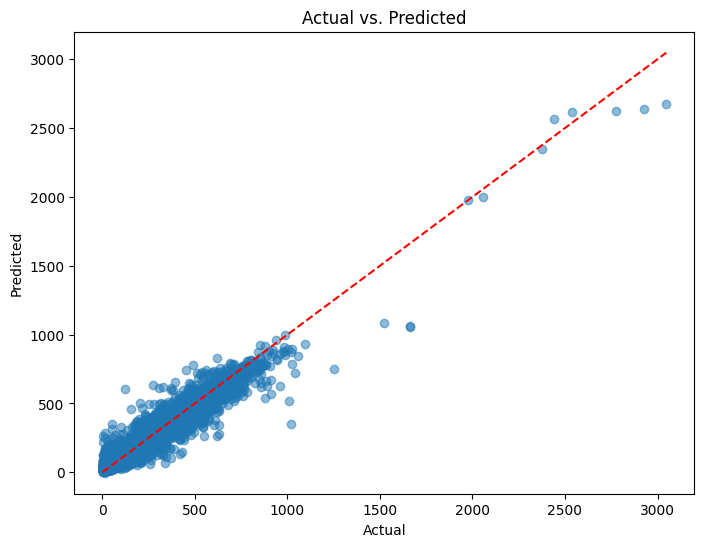

In [8]:
# Predict on the validation set
preds = gbm.predict(X_valid)

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, preds, alpha=0.5)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

## The red dashed line indicates a perfect prediction where actual equals predicted.
## Points closer to this line represent better predictions.

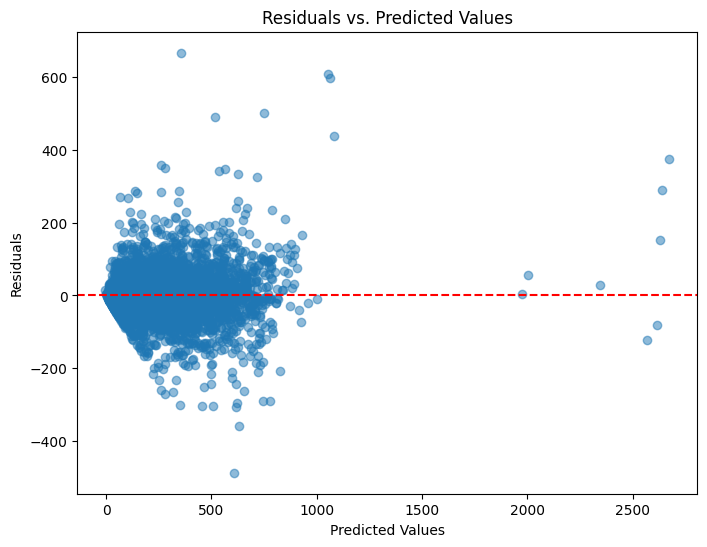

In [9]:
# Calculate residuals
residuals = y_valid - preds

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()